In [441]:
from atm_data.data_utils.weather_noaa_data import *
from pathlib import Path
from ast import literal_eval
import pandas as pd
import numpy as np
import functools

import matplotlib.pyplot as plt
from matplotlib import cm, colors
from scipy.stats import gaussian_kde as kde

from scipy.stats import pearsonr


In [285]:
data_dir = Path.cwd().resolve().parent / 'data'
weather_path = data_dir / 'noaa_lcdv2/lcd_lga_1987-2023_cleaned.parquet'
# TODO: handling in the bayesair remapped to like not have to do the "_decade" suffix
schedule_path = data_dir / 'bts_remapped/lga_reduced_2010-2019_clean_decade/parquet/lga_reduced_2010-2019_clean_decade.parquet'

# start_date = "2019-07-01"
# end_date = "2019-08-01" # exclusive

start_date = "2010-01-01"
end_date = "2020-01-01" # exclusive

wdf = pd.read_parquet(weather_path)
sdf = pd.read_parquet(schedule_path)
sdf = (
    sdf.set_index(
        pd.DatetimeIndex(sdf['date'])
    )
    .drop(['date'], axis=1)
)

wdf = wdf.loc[(wdf.index >= start_date) & (wdf.index < end_date)]
sdf = sdf.loc[(sdf.index >= start_date) & (sdf.index < end_date)]

for df in (wdf, sdf):
    display(df)
    display(df.dtypes)


,hourly_alitmeter_setting,hourly_dew_point_temperature,hourly_dry_bulb_temperature,hourly_precipitation,hourly_relative_humidity,hourly_visibility,hourly_wind_direction,hourly_wind_speed,hourly_wind_gust_speed,hpwt_BCFG,...,hsc_layer_1_height,hsc_layer_2_height,hsc_layer_3_height,hsc_total_coverage,hsc_total_amount,hsc_total_height,hsc_ceiling_coverage,hsc_ceiling_amount,hsc_ceiling_height,hourly_sky_conditions
date,,,,,,,,,,,,,,,,,,,,,
2010-01-01 00:00:00,1015.2,-0.6,0.6,0.3,92.0,4.023,60.0,1.5,0.0,False,...,1.52,4.27,NaN,OVC,8.0,4.27,OVC,8.0,4.27,SCT:04-1.52 OVC:08-4.27
2010-01-01 01:00:00,1015.2,0.0,1.1,0.0,92.0,4.023,60.0,0.0,0.0,False,...,1.83,4.27,NaN,OVC,8.0,4.27,BKN,7.0,1.83,BKN:07-1.83 OVC:08-4.27
2010-01-01 02:00:00,1014.9,0.0,1.1,0.0,92.0,4.828,80.0,1.5,0.0,False,...,1.83,NaN,NaN,OVC,8.0,1.83,OVC,8.0,1.83,OVC:08-1.83
2010-01-01 03:00:00,1014.6,0.0,0.6,0.0,96.0,8.047,90.0,0.0,0.0,False,...,1.83,NaN,NaN,OVC,8.0,1.83,OVC,8.0,1.83,OVC:08-1.83
2010-01-01 04:00:00,1014.2,0.0,0.6,0.0,96.0,8.047,100.0,1.5,0.0,False,...,1.83,NaN,NaN,OVC,8.0,1.83,OVC,8.0,1.83,OVC:08-1.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,1003.0,1.7,7.2,0.0,68.0,16.093,210.0,4.6,0.0,False,...,15.24,18.29,NaN,OVC,8.0,18.29,BKN,7.0,15.24,BKN:07-15.24 OVC:08-18.29
2019-12-31 20:00:00,1004.1,1.1,6.7,0.3,68.0,16.093,280.0,7.2,12.4,False,...,8.23,10.06,14.94,OVC,8.0,14.94,OVC,8.0,14.94,FEW:02-8.23 SCT:04-10.06 OVC:08-14.94
2019-12-31 21:00:00,1003.7,0.0,6.1,0.0,65.0,16.093,270.0,6.2,10.8,False,...,8.23,16.76,NaN,OVC,8.0,16.76,OVC,8.0,16.76,FEW:02-8.23 OVC:08-16.76


hourly_alitmeter_setting         float64
hourly_dew_point_temperature     float64
hourly_dry_bulb_temperature      float64
hourly_precipitation             float64
hourly_relative_humidity         float64
hourly_visibility                float64
hourly_wind_direction            float64
hourly_wind_speed                float64
hourly_wind_gust_speed           float64
hpwt_BCFG                        boolean
hpwt_BL                          boolean
hpwt_BLSN                        boolean
hpwt_BR                          boolean
hpwt_DRSN                        boolean
hpwt_DZ                          boolean
hpwt_FG                          boolean
hpwt_FU                          boolean
hpwt_FZDZ                        boolean
hpwt_FZFG                        boolean
hpwt_FZRA                        boolean
hpwt_GR                          boolean
hpwt_GS                          boolean
hpwt_HAIL                        boolean
hpwt_HZ                          boolean
hpwt_MIFG       

,flight_number,tail_number,origin_airport,destination_airport,scheduled_departure_time,scheduled_arrival_time,actual_departure_time,actual_arrival_time,wheels_off_time,wheels_on_time,...,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,cancelled,cancellation_code,diverted,diverted_reached_destination,diverted_airport_landings
date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,AA:705,N4XPAA,LGA,DFW,6.000000,10.083333,5.916667,9.833333,6.183333,9.750000,...,0.00,0.0,0.000000,0.0,0.0,False,Z,False,<NA>,0
2010-01-01,AA:2257,N5DCAA,LGA,MIA,6.000000,9.166667,6.100000,9.433333,6.533333,9.316667,...,0.00,0.1,0.166667,0.0,0.0,False,Z,False,<NA>,0
2010-01-01,B6:371,N661JB,LGA,FLL,6.000000,8.950000,6.050000,9.650000,6.766667,9.566667,...,0.05,0.0,0.650000,0.0,0.0,False,Z,False,<NA>,0
2010-01-01,DL:1769,N676DL,LGA,ATL,6.000000,8.733333,6.000000,8.616667,6.283333,8.466667,...,0.00,0.0,0.000000,0.0,0.0,False,Z,False,<NA>,0
2010-01-01,FL:359,N338AT,LGA,ATL,6.000000,8.600000,5.950000,8.900000,6.433333,8.750000,...,0.00,0.0,0.300000,0.0,0.0,False,Z,False,<NA>,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31,B6:1332,N328JB,LGA,BOS,21.500000,22.683333,21.200000,22.250000,21.400000,22.100000,...,0.00,0.0,0.000000,0.0,0.0,False,Z,False,<NA>,0
2019-12-31,DL:2814,N321DH,ATL,LGA,21.500000,23.633333,21.466667,23.350000,21.650000,23.233333,...,0.00,0.0,0.000000,0.0,0.0,False,Z,False,<NA>,0
2019-12-31,B6:1431,N198JB,BOS,LGA,21.500000,22.783333,21.616667,22.516667,21.850000,22.483333,...,0.00,0.0,0.000000,0.0,0.0,False,Z,False,<NA>,0


flight_number                   string[python]
tail_number                     string[python]
origin_airport                  string[python]
destination_airport             string[python]
scheduled_departure_time               float64
scheduled_arrival_time                 float64
actual_departure_time                  float64
actual_arrival_time                    float64
wheels_off_time                        float64
wheels_on_time                         float64
departure_delay                        float64
arrival_delay                          float64
carrier_delay                          float64
weather_delay                          float64
nas_delay                              float64
security_delay                         float64
late_aircraft_delay                    float64
cancelled                              boolean
cancellation_code                     category
diverted                               boolean
diverted_reached_destination           boolean
diverted_airp

In [286]:
# TODO: some stats

In [381]:
def plot_condition_and_delays(
    type, 
    # these should be aligned time-wise
    conditions,
    dep_delays,
    arr_delays,
    start,
    end,
    condition_aggregation,
    delay_aggregation,
    colors = ('blue', 'red', 'orange'),
    figsize = (8,8)
):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax2 = ax.twinx()

    ax.plot(conditions, color=colors[0], label=f'{type}')
    ax2.plot(dep_delays, color=colors[1], label='departure delay')
    ax2.plot(arr_delays, color=colors[2], label='arrival delay')

    add_decorations(fig, ax, ax2, type, condition_aggregation, delay_aggregation, start, end, 'horizontal')

    return fig


def scatter_condition_and_delays(
    type, 
    # these should be aligned time-wise
    conditions,
    dep_delays,
    arr_delays,
    start,
    end,
    condition_aggregation,
    delay_aggregation,
    colors = ('blue', 'red', 'orange'),
    figsize = (8,8)
):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)

    def plot_scatter_and_trend(ax, x, y, color, linestyle='-', marker='.', label=None, d=1):        
        ax.scatter(x, y, color=c, marker=marker, label=label)
        z = np.polyfit(x, y, deg=d)
        p = np.poly1d(z)
        plt.plot(x, p(x), color=color, linestyle=linestyle)

    x = conditions
    for y, c, l in ((dep_delays, colors[1], 'departure'), (arr_delays, colors[2], 'arrival')):
        r, _ = pearsonr(x, y)
        plot_scatter_and_trend(ax, x.to_numpy(), y.to_numpy(), c, label=f'{l}, ρ={r:.03f}')

    add_decorations(fig, ax, None, type, condition_aggregation, delay_aggregation, start, end, 'vertical')

    return fig


def add_decorations(
    fig, ax, ax2, type, condition_aggregation, delay_aggregation, start, end, side
):
    if side == 'horizontal':
        set_condition_label = ax.set_ylabel
        set_delay_label = ax2.set_ylabel
        ax.set_ylim(bottom=0)
        add_flight_rule_regions(ax, type, 'horizontal')
        ax.set_xlabel('date')
        fig.legend()
    elif side == 'vertical':
        set_condition_label = ax.set_xlabel
        set_delay_label = ax.set_ylabel
        ax.set_xlim(left=0)
        add_flight_rule_regions(ax, type, 'vertical')
        ax.legend()
    else:
        raise ValueError

    set_condition_label(
        f"{type} {'(ft)' if type == 'ceiling' else '(mi)'} -- lower is worse -- [{condition_aggregation}]"
    )
    set_delay_label(f'delay (hrs) -- higher is worse -- [{delay_aggregation}]')

    ax.set_title(
        f'{type} and delays between {start} and {end}'
    )


def add_flight_rule_regions(
    ax, 
    type,
    side, 
    thresholds=None,
    colors=None,
    alpha=.2,
    linestyle='--',
):
    if side == 'horizontal':
        add_line = ax.axhline
        add_span = ax.axhspan
        cmin, cmax = ax.get_ylim()            
    elif side == 'vertical':
        add_line = ax.axvline
        add_span = ax.axvspan
        cmin, cmax = ax.get_xlim()
    else:
        raise ValueError('type must be horizontal or vertical :(')

    if thresholds is None:
        if type == 'ceiling':
            thresholds = [500, 1000, 3200]
        elif type == 'visibility':
            thresholds = [1, 3, 4]
        else:
            raise ValueError('type must be ceiling or visibility')
    else:
        assert len(thresholds) == 3 # TODO: generalize??
        
    if colors is None:
        colors = ['darkred', 'red', 'yellow', 'lightgreen']
    else:
        assert len(colors) == 4 # TODO: generalize??

    for threshold, color in zip(thresholds, colors):
        add_line(threshold, color=color, linestyle=linestyle)
    
    span_lo = [cmin] + thresholds
    span_hi = thresholds + [cmax]

    labels = [
        'LIFR (low IFR)',
        'IFR (instrument)',
        'MVFR (marginal)',
        'VFR (visual)',
    ]
    
    for lo, hi, color, label in zip(span_lo, span_hi, colors, labels):
        add_span(lo, hi, facecolor=color, alpha=alpha, label=label)



In [417]:
# TODO: maybe we can auto-generate a description??
def process_series(
    s,
    *argv,
):
    # print(argv)
    for arg in argv:
        # print(arg, type(arg))
        if isinstance(arg, str):
            action = arg
            if action == 'no_inf':
                s = s.loc[~s.isin([np.inf])]
            elif action == 'no_nan':
                s = s.loc[~s.isin([np.nan])]
            elif action == 'inverse':
                s = 1.0 / s
        elif isinstance(arg, (list, tuple, np.ndarray)):
            action = arg[0]
            if action == 'scale':
                s = s * arg[1]
            elif action == 'clip':
                s = s.clip(lower=arg[1], upper=arg[2])
            elif action == 'filter_index':
                s = s.loc[(arg[1] <= s.index) & (s.index < arg[2])]
            elif action == 'apply_func':
                s = s.apply(arg[1])
            elif action == 'apply_func_vec':
                s = arg[1](s)
            else:
                sg = s.groupby(pd.Grouper(freq=arg[1]))
                if action == 'mean':
                    s = sg.mean()
                elif action == 'min':
                    s = sg.min()
                elif action == 'max':
                    s = sg.max()
                else:
                    raise ValueError(f'invalid step: {arg}')
    return s

freq = '1D'
ceiling = wdf.hsc_ceiling_height

process_ceiling = functools.partial(process_series, ceiling)

ch_daily_finite_mean = process_ceiling(
    'no_inf', 'no_nan', ('mean', freq)
)

ch_daily_min = process_ceiling(
    'min'
)

ch_daily_inverse_mean = process_ceiling(
    'inverse', ('mean', freq)
)
ch_daily_harmonic_mean = process_series(
    ch_daily_inverse_mean, 'inverse'
)

ch_hourly_clipped = process_ceiling(
    ('clip', .5, 64)
)

ch_daily_clipped_mean = process_series(
    ch_hourly_clipped, ('mean', freq)
)

ch_daily_clipped_inverse_mean = process_series(
    ch_hourly_clipped, ('inverse'), ('mean', freq)  
)

ch_daily_clipped_harmonic_mean = process_series(
    ch_daily_clipped_inverse_mean, ('inverse')
)

# display(ch_daily_clipped_harmonic_mean.nsmallest(5))

sdf_outgoing = sdf.loc[sdf.origin_airport == 'LGA']
sdf_incoming = sdf.loc[sdf.destination_airport == 'LGA']

dep_delay_daily = process_series(
    sdf_outgoing.departure_delay, ('mean', freq)
)
arr_delay_daily = process_series(
    sdf_incoming.arrival_delay, ('mean', freq)
)


In [415]:
# show that we can do these from scratch easily!
# though maybe kinda silly and not much benefit over pandas methods
freq = '1D'
start = '2019-07-01'
end = '2019-08-01'

processed_ceiling = process_series(
    wdf.hsc_ceiling_height,
    ('filter_index', start, end),
    ('clip', .5, 64), 
    ('scale', 100), 
    ('inverse'), 
    ('mean', freq), 
    ('inverse'),
)
v = processed_ceiling

d = process_series(
    sdf_outgoing.departure_delay,
    ('filter_index', start, end),
    ('mean', freq),
)

a = process_series(
    sdf_incoming.arrival_delay,
    ('filter_index', start, end),
    ('mean', freq),
)

fig = plot_condition_and_delays(
    type='ceiling', 
    conditions=v,
    dep_delays=d,
    arr_delays=a,
    start=start,
    end=end,
    condition_aggregation='daily clipped harmonic mean',
    delay_aggregation='daily mean',
    figsize=(12,8)
)

ValueError: Invalid frequency: 2019-07-01

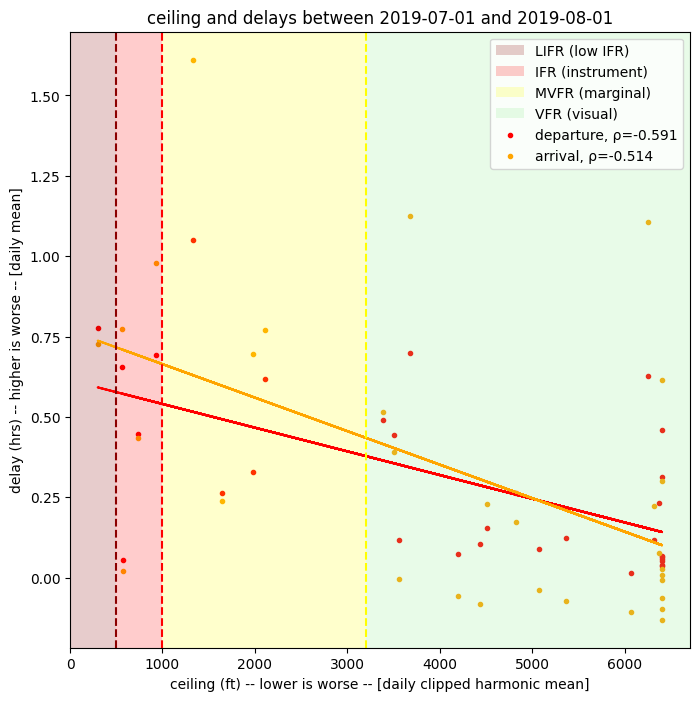

In [396]:
fig = scatter_condition_and_delays(
    type='ceiling', 
    conditions=v,
    dep_delays=d,
    arr_delays=a,
    start=start,
    end=end,
    condition_aggregation='daily clipped harmonic mean',
    delay_aggregation='daily mean',
    figsize=(8,8)
)

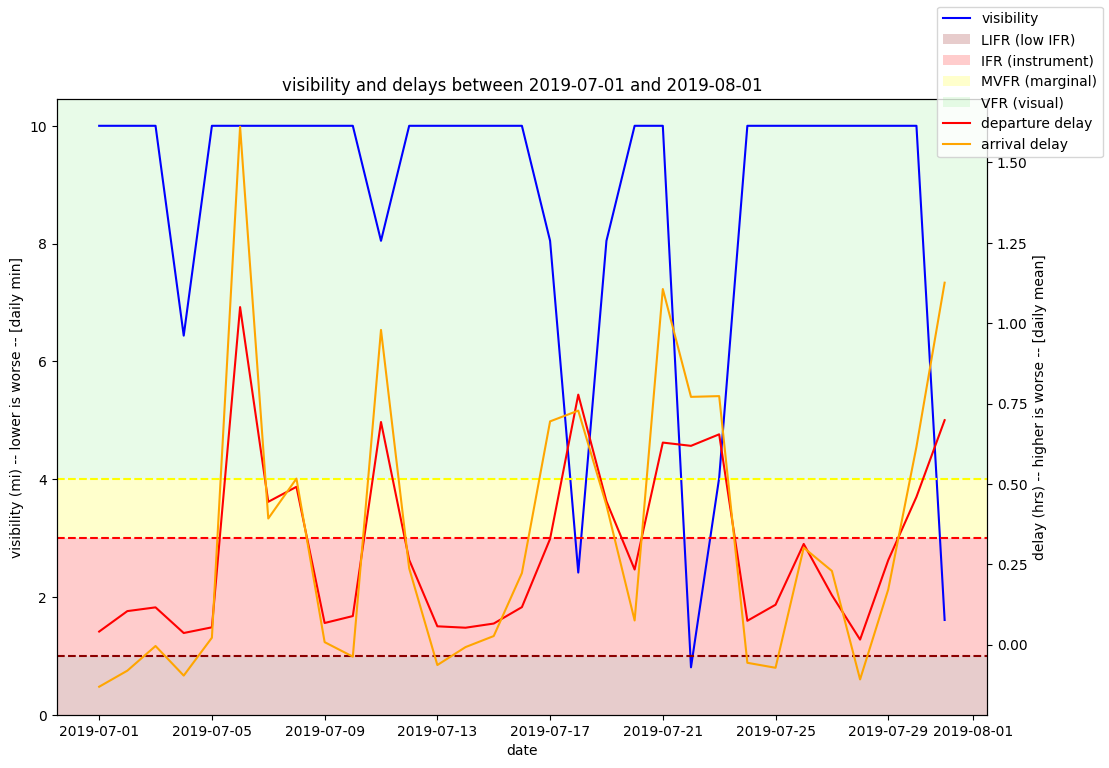

In [397]:
processed_visibility = process_series(
    wdf.hourly_visibility,
    ('filter_index', start, end),
    ('clip', .001, 10), 
    # ('inverse'), 
    # ('mean', freq), 
    # ('inverse'),
    ('min', freq)
)

v = processed_visibility

fig = plot_condition_and_delays(
    type='visibility', 
    conditions=v,
    dep_delays=d,
    arr_delays=a,
    start=start,
    end=end,
    condition_aggregation='daily min',
    delay_aggregation='daily mean',
    figsize=(12,8)
)

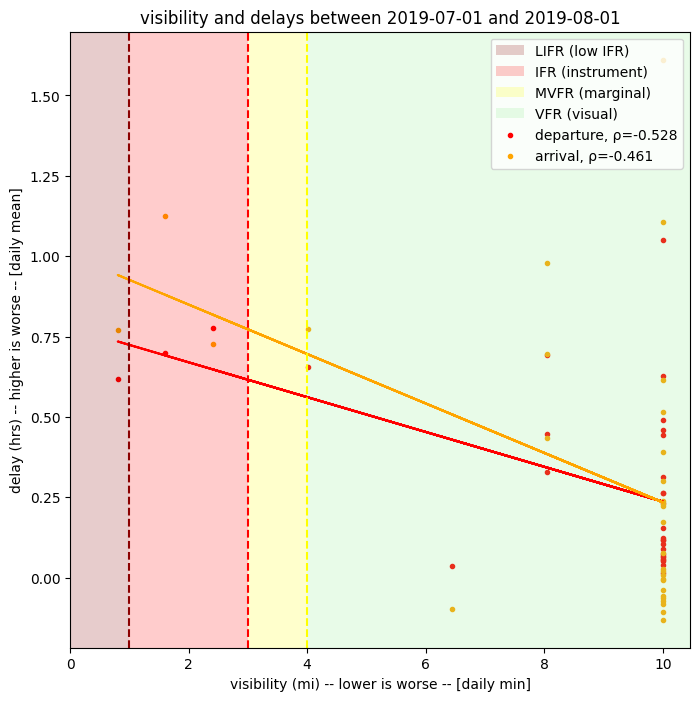

In [398]:
fig = scatter_condition_and_delays(
    type='visibility', 
    conditions=v,
    dep_delays=d,
    arr_delays=a,
    start=start,
    end=end,
    condition_aggregation='daily min',
    delay_aggregation='daily mean',
    figsize=(8,8)
)

Text(0, 0.5, 'visibility (mi)')

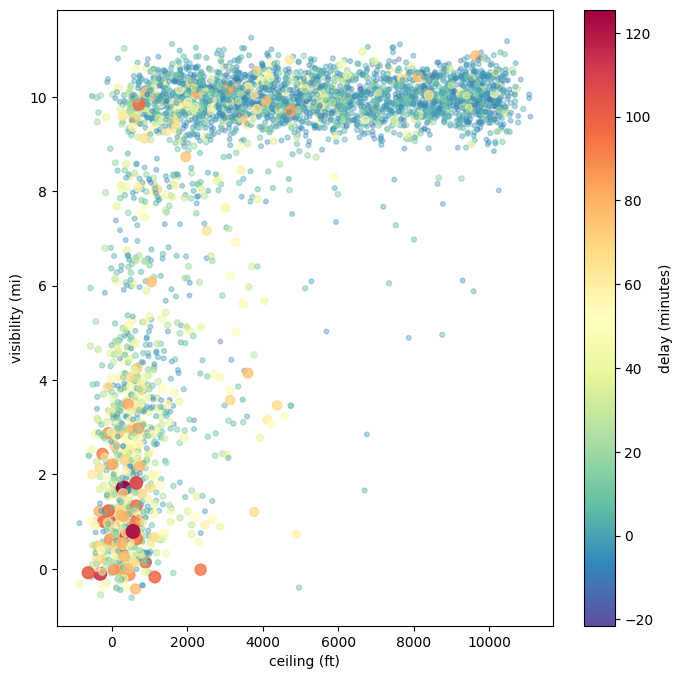

In [531]:
freq = '1D'
start = '2010-01-01'
end = '2020-01-01'

processed_ceiling = process_series(
    wdf.hsc_ceiling_height,
    ('filter_index', start, end),
    ('clip', .1, 100), 
    ('scale', 100), 
    ('inverse'), 
    ('mean', freq), 
    ('inverse'),
)

processed_visibility = process_series(
    wdf.hourly_visibility,
    ('filter_index', start, end),
    ('clip', .001, 10), 
    # ('inverse'), 
    # ('mean', freq), 
    # ('inverse'),
    ('min', freq)
)

d = process_series(
    sdf_outgoing.departure_delay,
    ('filter_index', start, end),
    ('mean', freq),
)

a = process_series(
    sdf_incoming.arrival_delay,
    ('filter_index', start, end),
    ('mean', freq),
)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

samples = np.array(processed_ceiling, processed_visibility)

# define color map
cmap = cm.get_cmap("Spectral_r")
# c = kde(samples).evaluate(samples)
c = a.to_numpy() * 60 #* kde(samples).evaluate(samples)

norm = colors.Normalize(min(c), max(c))

def rand_jitter(arr, k=.01):
    stdev = (.01 if k is None else k) * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def jitter(ax, x, y, s=20, c='b', marker='o', cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, verts=None, hold=None, k=None, **kwargs):
    return ax.scatter(rand_jitter(x, k), rand_jitter(y, k), s=s, c=c, marker=marker, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, alpha=alpha, linewidths=linewidths, **kwargs)

cn = ((c-min(c))/(max(c)-min(c)))
cns = 90*(cn**2)+10
cna = .7*cn+.3
jitter(ax, processed_ceiling, processed_visibility, c=c, cmap=cmap, alpha=cna, s=cns, k=.04)

# ax.set_xlim(-80, 4000)
# ax.set_ylim(-.1, 5)
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
cbar.set_label('delay (minutes)')

ax.set_xlabel('ceiling (ft)')
ax.set_ylabel('visibility (mi)')